In [93]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [94]:
#데이터 로드

train_data = pd.read_table('ratings_train_all.txt')
test_data = pd.read_table('여신강림1회_댓글라벨링.txt', encoding='cp949') #우리가 라벨링한것
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))

훈련용 리뷰 개수 : 200000
테스트용 리뷰 개수 : 88


In [95]:
#시간너무걸리니 랜덤샘플링   -실제 제출할떈 지우기!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
train_data = train_data.sample(n=30000, random_state=0)

In [96]:
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))

훈련용 리뷰 개수 : 30000
테스트용 리뷰 개수 : 88


In [97]:
#중복 데이터 수
train_data['document'].nunique(), train_data['label'].nunique()

# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True) 

In [98]:
#중복 제거 후 샘플 수
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 29568


In [99]:
# 트레인셋의 라벨 수
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  14822
1      1  14746


In [100]:
#결측치있다면 삭제
if train_data.isnull().values.any() ==True:
    train_data = train_data.dropna(how = 'any')
    print('결측치 제거 후 갯수')
    len(train_data)

결측치 제거 후 갯수


In [101]:
'''
#영어에서 잡 문자 제거
text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거
'''

"\n#영어에서 잡 문자 제거\ntext = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'\nre.sub(r'[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거\n"

In [102]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

<ipython-input-102-7c6e437d390d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
54458,2920361,오웬 윌슨 성룡다 최고의 배우,1
118646,5614748,반전이 조금 어이없었던 것 빼고는 정말 슬프고 아렸던 영화 ㅠㅠ,1
57401,7381910,아이에게 의리를 가르치고 싶다면 영웅을 보라,0
115324,1552619,평점왜이래정말 진정한느와르,1
71684,1616608,음악이 압권 복고풍효과음이 가장인상깊은,1


In [103]:
#위에서 한글과 공백만 남겨서, 다시 공백이 생겼을 것임. 이들을 확인
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)

train_data = train_data.dropna(how = 'any')
print('다시 생긴 공백이 있다면 삭제')
print('학습데이터 길이 : ' + str(len(train_data)))

다시 생긴 공백이 있다면 삭제
학습데이터 길이 : 29377


<ipython-input-103-60360b2582a2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [104]:
#테스트셋도 전처리
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 84


<ipython-input-104-97a1cf8be4ba>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-104-97a1cf8be4ba>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [105]:
#불용어 지정 및 형태소 분리
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

#형태소분리
okt = Okt()

X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 형태소분리
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)
    
    
X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [106]:
#제대로 분리 됐는지 확인해보기
print(X_train[:3])

[['오웬', '윌슨', '성룡', '다', '최고', '배우'], ['반전', '조금', '어이없다', '것', '빼다', '정말', '슬프다', '아리다', '영화', 'ㅠㅠ'], ['아이', '에게', '의리', '가르치다', '싶다', '영웅', '을', '보라']]


In [107]:
#정수인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(str(X_train))

In [108]:
print(tokenizer.word_index)

{"'": 1, '다': 2, '이': 3, '하': 4, '화': 5, '영': 6, '보': 7, '지': 8, '기': 9, '나': 10, '리': 11, '아': 12, 'ㅋ': 13, '고': 14, '만': 15, '재': 16, '인': 17, '그': 18, '가': 19, '라': 20, '스': 21, '무': 22, '을': 23, '로': 24, '시': 25, '없': 26, '정': 27, '미': 28, '어': 29, '대': 30, '오': 31, '말': 32, '사': 33, '도': 34, '점': 35, '주': 36, '마': 37, '자': 38, '있': 39, '연': 40, '에': 41, '서': 42, '감': 43, '니': 44, '내': 45, '전': 46, '진': 47, '우': 48, '들': 49, '좋': 50, '작': 51, '장': 52, '너': 53, '수': 54, '되': 55, '상': 56, '안': 57, '게': 58, '생': 59, '적': 60, '짜': 61, '드': 62, '렇': 63, '한': 64, '제': 65, '여': 66, '최': 67, '해': 68, '부': 69, '모': 70, '치': 71, '개': 72, '르': 73, '간': 74, '동': 75, '요': 76, '같': 77, 'ㅠ': 78, '소': 79, '거': 80, '일': 81, '중': 82, '밌': 83, '음': 84, '평': 85, '성': 86, '비': 87, '배': 88, '때': 89, '신': 90, '각': 91, '않': 92, '더': 93, '분': 94, '공': 95, '유': 96, '레': 97, '토': 98, '구': 99, '는': 100, '것': 101, '야': 102, '용': 103, '루': 104, '국': 105, '실': 106, '건': 107, '면': 108, '랑': 109, '저': 110, '데': 11

In [109]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1802
등장 빈도가 2번 이하인 희귀 단어의 수: 420
단어 집합에서 희귀 단어의 비율: 23.307436182019977
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.03978494787562097


In [110]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1383


In [111]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [112]:
#정수인코딩 확인
print(X_train[:3])

[[689, 9, 28, 43], [169, 315, 518, 25, 382, 10, 206, 1, 84], [205, 154, 1148, 71, 961, 3]]


In [113]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [116]:
# 빈도수 적은 단어들 삭제해서 빈 샘플들이 생겼음. 이를 다시 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

28960
28960


리뷰의 최대 길이 : 49
리뷰의 평균 길이 : 8.602417127071822


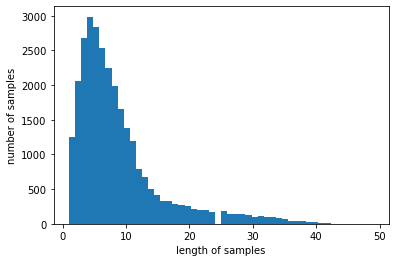

In [117]:
#패딩하기 전에 문장길이 분포부터 확인
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [120]:
#지정한 길이 이상길이 샘플 삭제
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [119]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 97.73480662983425


In [121]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [33]:
#lstm으로 네이버 영화 리뷰 감성 분류하기

In [34]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [122]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [123]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [124]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
387/387 [==============================] - 17s 41ms/step - loss: 0.4664 - acc: 0.7757 - val_loss: 0.4314 - val_acc: 0.7956

Epoch 00001: val_acc improved from -inf to 0.79558, saving model to best_model.h5
Epoch 2/15
387/387 [==============================] - 13s 34ms/step - loss: 0.3905 - acc: 0.8222 - val_loss: 0.4185 - val_acc: 0.8101

Epoch 00002: val_acc improved from 0.79558 to 0.81008, saving model to best_model.h5
Epoch 3/15
387/387 [==============================] - 13s 34ms/step - loss: 0.3752 - acc: 0.8313 - val_loss: 0.4260 - val_acc: 0.8090

Epoch 00003: val_acc did not improve from 0.81008
Epoch 4/15
387/387 [==============================] - 13s 32ms/step - loss: 0.3601 - acc: 0.8390 - val_loss: 0.4080 - val_acc: 0.8182

Epoch 00004: val_acc improved from 0.81008 to 0.81820, saving model to best_model.h5
Epoch 5/15
387/387 [==============================] - 13s 32ms/step - loss: 0.3451 - acc: 0.8456 - val_loss: 0.4038 - val_acc: 0.8182

Epoch 00005: val_acc di

In [128]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

3/3 [==============================] - 0s 14ms/step - loss: 0.7210 - acc: 0.6905

 테스트 정확도: 0.6905


In [142]:
#파일 넣으면 알아서 해주는 모델 만들기
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    #if(score > 0.5):
    #  print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    #else:
    #  print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
    return score

In [148]:
#댓글 불러운 뒤 앞에 best글자 없애기
webtoon_comment = pd.read_table("여신강림1회_댓글라벨링.txt", encoding='cp949')

for k in range(0,len(webtoon_comment['document'])):
    webtoon_comment['document'][k] = re.sub("BEST", "", webtoon_comment['document'][k])

webtoon_comment['document'] = webtoon_comment['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

webtoon_comment

<ipython-input-148-c19356276ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  webtoon_comment['document'][k] = re.sub("BEST", "", webtoon_comment['document'][k])
<ipython-input-148-c19356276ac3>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  webtoon_comment['document'] = webtoon_comment['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


,id,document,label
0,1,스토리가 완전 별로임이게 조연들 스토리인지 주인공 스토리인지 분간이 안감조연들 이어...,0
1,1,여신 강림 드라마 어제 오늘 정주행하고 결말보고 행복해졌어요 원작 궁금해서 화부터 ...,1
2,1,마지막에 반반이 나와서 웃겼어요ㅋㅋㅋㅋㅋ여신강림 오늘 봐서 웃곀요ㅋㅋㅋㅋ,1
3,1,점점 갈 수록 그림체가 예뻐지면서 이야기는 산으로 가고,0
4,1,와 얼굴성형화장한건가,1
...,...,...,...
83,1,클린봇이 부적절한 표현을 감지한 댓글입니다,0
84,1,님 죄송한데그러면 화장하지 마세여,1
85,1,이때 그림체 좋다,1
86,1,여신강림 쿠키까지 구워서 다보고 볼게 없어서첫화 보러온사람 좋아요 눌러주세요,1


In [146]:
pred_label=[]
for sentence in webtoon_comment['document']:
    print(sentence)
    print(sentiment_predict(sentence))
    if sentiment_predict(sentence) >0.5:
        pred_label.append(1)
    else :
        pred_label.append(0)

  #pred_label.append(sentiment_predict(sentence))

스토리가 완전 별로임이게 조연들 스토리인지 주인공 스토리인지 분간이 안감조연들 이어주느라 막상 주인공들은 이어지지도 않음
0.03334325551986694
여신 강림 드라마 어제 오늘 정주행하고 결말보고 행복해졌어요 원작 궁금해서 화부터 달립니다
0.8293551206588745
마지막에 반반이 나와서 웃겼어요ㅋㅋㅋㅋㅋ여신강림 오늘 봐서 웃곀요ㅋㅋㅋㅋ
0.9824886322021484
점점 갈 수록 그림체가 예뻐지면서 이야기는 산으로 가고
0.2234291136264801
와 얼굴성형화장한건가
0.2000611424446106
한이 한서이라는게 학교의 점심
0.36381804943084717
그래 이제 난 이 웹툰 그냥 그림 보는 정도로만 보고있을래솔직히 프롤로그가 제일 나았다
0.5118952393531799
페미들 점령했노ㅠ
0.6785858869552612
ㅋ
0.7209915518760681
야옹이님 펜이에요
0.8989547491073608
ㅌㅋㅋㅋㅋㅋㅋ
0.4773913323879242
클린봇이 부적절한 표현을 감지한 댓글입니다
0.5129712224006653
와진짜프롤로그부터너무 재밌어이런 띵작 보여주셔서 감사합니다
0.9970318675041199
역시 여신강림 첫 회부터가 짱이다너무 재밌게 보고 있답니다
0.9924907088279724
너무재미있어요작가님
0.8530915975570679
걍 핵피엔딩 내고 끝내라
0.4840293824672699
와 예전에 보고 못봤는데 오랜만이다
0.6609330773353577
처음이때까지만 해도 좋았는데
0.8959752917289734
야옹이 작가님잠깐동안 그림 저장하겠습니다죄송합니다
0.40013399720191956
남친있냐고물어본 아이돌은 생각이 있는건가
0.3847324252128601
솔까 이작품 첫시작은 레알 괜찮았는데 갈수록 여주도 별로고 ㅈㄴ 답답함 서브가 개불쌍하게 나오고 ㄹㅇ 쿠키 지르기가 아까움
0.002808213233947754
지금 보니까 프롤로그에 비해 스토리라인이 너무 

In [152]:
import sklearn.metrics as metrics

print('accuracy', metrics.accuracy_score(webtoon_comment['label'], pred_label))
print('precision', metrics.precision_score(webtoon_comment['label'], pred_label) )
print('recall', metrics.recall_score(webtoon_comment['label'], pred_label) )
print('f1', metrics.f1_score(webtoon_comment['label'], pred_label) )
print()
print()
print(metrics.classification_report(webtoon_comment['label'], pred_label))
print(metrics.confusion_matrix(webtoon_comment['label'], pred_label))
print()
print()

accuracy 0.6818181818181818
precision 0.7884615384615384
recall 0.7068965517241379
f1 0.7454545454545455


              precision    recall  f1-score   support

           0       0.53      0.63      0.58        30
           1       0.79      0.71      0.75        58

    accuracy                           0.68        88
   macro avg       0.66      0.67      0.66        88
weighted avg       0.70      0.68      0.69        88

[[19 11]
 [17 41]]


